### [unused] Nitrate vs density gradient strength

# surface nitrate summer limitation map

Make custom diverging color map:

# Laptev Nitrate profiles

In [ ]:
df_single, df = load_data()

In [ ]:
(
    df.loc[df.lat.between(76, 77) & df.lon.between(124, 128)]
    .hvplot('nitrate', 'depth', by='station')
    .opts(invert_yaxis=True)
)

In [ ]:
(
    df.loc[df.lat.between(76, 77) & df.lon.between(124, 128)]
    .hvplot('sigth', 'depth', by='station')
    .opts(invert_yaxis=True)
)

Gradient:

In [ ]:
3/20

In [ ]:
(27-23)/20

# [do later] Interannual trends

obs:

- NC deepening in S Beaufort
- 

to do:
make 2dim hextiles aggregator, then plot hextiles of trends and significance

In [ ]:
df_per_station, df = load_data()

df = df.melt(['year', 'season', 'reg_name'], ['ntr0', 'nc', 'nc0']).dropna(subset=['season'])
df = df.loc[~df.reg_name.isnull()]

In [ ]:
df.reg_name.unique()

In [ ]:
m = df.hvplot.scatter('year', 'value', groupby=['reg_name', 'season', 'variable'])

from utils.holoviews.element import Regression

l=m*m.map(Regression, 'Scatter')

In [ ]:
%%opts Scatter [ frame_width=600 frame_height=400 show_grid=True invert_yaxis=True, legend_position='top']
l.overlay('season')#.layout('reg_name').cols(1)

## [unused] Scatter plots: Relations

deltanc vs surface NO3

NC vs MLD...

## GridMatrix (faceted)

# Data coverage of nitrate data

## Load data for analysis

Load data:
- df: dataframe 
- gdf geodataframe
- dfp: dataframe with full profiles

In [ ]:
# Per-station scalar quantities
df = pd.read_csv('../nb_data/no3-compilation/database-per-stn.csv', parse_dates=['date'])
# full-depth profiles
dfp = pd.read_csv('../nb_data/no3-compilation/database.csv', parse_dates=['date'])

df_regions = gpd.read_file('../input_data/regions/arctic-regions.shp')
regions = gv.Polygons(df_regions, kdims=['Longitude', 'Latitude'], vdims=['reg_idx', 'reg_name'])

## Profiles per year

In [ ]:
d = df.groupby(['lon', 'lat', 'date']).first().reset_index()[['station', 'year']].assign(station=1)

In [ ]:
d.groupby('year').count().plot()
plt.yscale('log')

## Geographical distribution of profiles

The majority of profiles is from the Fram Strait and Bering Strait areas:

Median year of profile collection.

# [only for GRC talk?] Re-visit stratification ice vs open water

In [11]:
m = loadmat('/Users/doppler/database/nitrate-fluxes/CB2014_MSS_set_average.mat', squeeze_me=True)

In [12]:
m['CTD'].dtype

dtype([('C', 'O'), ('N', 'O'), ('PT', 'O'), ('S', 'O'), ('SIGTH', 'O'), ('T', 'O'), ('chla', 'O'), ('dThorpe', 'O'), ('drhoThorpe', 'O'), ('z', 'O'), ('P', 'O'), ('NTR', 'O'), ('SIGTH_ISUS', 'O'), ('chla_ROS', 'O')])

In [13]:
isice = m['STA']['ice'].astype(bool)

In [14]:
pres = m['CTD']['P'][0]

In [15]:
sigth = np.vstack(m['CTD']['SIGTH']).transpose()

In [16]:
pres_e = m['MIX']['P'][0]

In [17]:
eps = np.vstack(m['MIX']['eps']).transpose()

In [ ]:
data = {
    {True: 'Ice covered', False: 'Open Water'}[k]: hv.Curve((pres_e, np.nanmean(eps[:, isice==k], axis=1)), hv.Dimension('Pressure', unit='dbar'),
                hv.Dimension('eps', unit=u'W kg\u207B\u2071'))
    for k in [False, True]
}

l = hv.NdOverlay(data, ['Ice?'])
l.opts(
    opts.Curve(invert_axes=True, invert_yaxis=True, xlim=(3, 60), logx=True),
    opts.NdOverlay(legend_position='bottom')
)
hv.renderer('matplotlib').save(l, '../nb_fig/underice_eps', fmt='pdf')
l

In [ ]:
data = {
    {True: 'Ice covered', False: 'Open Water'}[k]: hv.Curve((pres, np.nanmedian(sigth[:, isice==k], axis=1)), hv.Dimension('Pressure', unit='dbar'),
                hv.Dimension('Density', unit=u'kg m\u207B\u00B3'))
    for k in [False, True]
}

l = hv.NdOverlay(data, ['Ice?'])
l.opts(
    opts.Curve(invert_axes=True, invert_yaxis=True, xlim=(3, 60)),
    opts.NdOverlay(legend_position='bottom')
)
hv.renderer('matplotlib').save(l, '../nb_fig/underice_strat', fmt='pdf')
l

In [ ]:
df = pd.DataFrame(sigth, index=pres).stack().rename_axis(['P', 'prof'])#.rename('')

# Attempt to predict winter fluxes everywhere based on winter surface NO3 conc. Can be done but where's the point?

## Regression 

In [ ]:
d = df[['FN', 'logFN', 'no3_sfc_winter']].dropna()

In [ ]:
import statsmodels.api as sm
# m = sm.OLS(d.FN, d.no3_sfc_winter)
m = sm.OLS(d.logFN, sm.add_constant(d.no3_sfc_winter))
m = m.fit()
m.summary()

In [ ]:
from sklearn import linear_model
m = linear_model.LinearRegression()
m = m.fit(d['no3_sfc_winter'].values[:, np.newaxis], d['logFN'])

In [ ]:
meas = hv.Scatter(df, 'no3_sfc_winter', 'FN').redim(**dims).opts(padding=.4, size=8)
# mod = hv.Curve(pd.DataFrame(dict(no3_sfc_winter=np.linspace(0,10,100), 
#                                  FN=10**(m.predict(sm.add_constant(np.linspace(0,10,100)))))
#                            ).sort_values('FN'))
ntrg = np.linspace(0,10,100)[:, np.newaxis]
mod = hv.Curve((ntrg, 10**m.predict(ntrg)))
              
meas * mod

## Pan-Arctic Map 

Need proper mask to restrict prediction to relevant areas only!

In [ ]:
d = [(-180, 90),
     (-180, 66), 
     (-115, 68),
     (-45, 66),
     (-45, 70),
     (15, 77),
     (25, 66),
     (180, 68),
     (180, 90)
    ]

domain = smoothen(shp.geometry.Polygon(d))
gv.Shape(domain).opts(
    opts.Shape(projection=ccrs.NorthPolarStereo())
) * gf.land

In [ ]:
ntr = pd.read_csv('../data/no3-compilation/database-per-stn.csv', parse_dates=['date'])

ntr = ntr.assign(logFN=lambda d: m.predict(d.ntr0[:, np.newaxis])).assign(FN=lambda d: 10**d.logFN)
ntr = ntr.loc[ntr.season=='winter']
ntr = ntr.loc[ntr.lat>=66]

In [ ]:
fn = gv.HexTiles(ntr, ['lon', 'lat'], ['logFN', 'FN', 'ntr0'])

options = (
    opts.HexTiles(projection=ccrs.NorthPolarStereo(), gridsize=14, colorbar=True, aggregator=np.nanmean,
                  tools=['hover'], #alpha=.4
#                   hooks=[logcolor_ticks(ticks=[1e-2, 1e-1, 1e0, 1e1, 1e2])]
                 ),
)

fn.opts(*options)
fn * gf.land

In [ ]:
m.predict(d[['ntr0']])

# Re-visit nitracline vs hBD vs MLD...

Plan:

1. Integrate CB data
1. do matchup per day (or else respect time)
1. reproject to x,y coords
1. set crit. cutoff at ~20 km
1. hextiles(nc-hbd, no3sig, aggregate mean(FN)) ?

## Prepare data

In [2]:
def ds_to_gdf(ds):
    for v in ['LATITUDE', 'LONGITUDE', 'TIME']:
        ds[v] = (['STATION'], ds[v])
    return ds.rename(dict(TIME='date'))

ds = xr.open_dataset('/Users/doppler/database/nitrate-fluxes-npdc/N-ICE2015-ISUS.nc')
isus_nice = ds_to_gdf(ds)

# mask out fill value, go from mol/m3 to mmol/m3
isus_nice['NITR'] = isus_nice['NITR'].where(isus_nice.NITR<50) *1e3

ds = xr.open_dataset('/Users/doppler/database/nitrate-fluxes-npdc/nice15_MSS_v2.nc')
mss_nice = ds_to_gdf(ds)

isus = isus_nice
mss = mss_nice

In [3]:
from scipy.spatial import cKDTree  
def ckdnearest(d1, d2, dist_tol=.1, t='date', t_tol=1, x='LONGITUDE', y='LATITUDE'):  
    """
    For each point in d1, find nearest point in d2, 
    and return a boolean index that is True iff their distance is less than dist_tol
    and they are not further apart in time than t_tol days.
    """
    n1 = np.array(list(zip(d1[x], d1[y])) )
    n2 = np.array(list(zip(d2[x], d2[y])) )
    tree_spatial = cKDTree(n2)
    distances, nearest = tree_spatial.query(n1)
    
    # for each point in d1, find all points in d2 within ttol days
    t1_epoch_days = (d1[t].values[:, np.newaxis] - np.datetime64('1900-01-01'))/np.timedelta64(1, 'D')
    t2_epoch_days = (d2[t].values[:, np.newaxis] - np.datetime64('1900-01-01'))/np.timedelta64(1, 'D')
    tree_tmp = cKDTree(t2_epoch_days)
    within_t_tol = tree_tmp.query_ball_point(t1_epoch_days, r=t_tol) # array of lists of pot. candidates
    
    within_tol = [True if idx in candidates and dist<=dist_tol else False 
                  for idx, dist, candidates in zip(nearest, distances, within_t_tol)]
    return nearest, within_tol

nearest, within_tol = ckdnearest(mss, isus)

for v in isus.variables:
    if v not in ['STATION', 'PRES', 'NITR']:
        isus = isus.rename({v: v+'_isus'})

isus = isus.isel(STATION=nearest).drop(['STATION'])

isus['within_tol'] = (['STATION'], within_tol)
isus = isus.where(isus.within_tol)

mss = mss.merge(isus).rename(dict(
    PRES='p', STATION='station', NITR='no3'
))

In [4]:
df = mss.copy()

df['depth'] = (['p'], -gsw.z_from_p(df.p, df.LATITUDE.mean()))
df['SA'] = (['station', 'p'], gsw.SA_from_SP(df.PSAL, df.p, df.LONGITUDE.mean(), df.LATITUDE.mean()))
df['CT'] = (['station', 'p'], gsw.CT_from_pt(df.SA, df.TEMP))
df['sigth'] = (['station', 'p'], gsw.sigma0(df.SA, df.CT))

ds = df.copy()

def sortvalues(dens, axis=0):
    return np.sort(dens)
ds['sigth_sort'] = ds.sigth.reduce(sortvalues, dim='p')

ds['N2_sorted'] = 9.81/(1e3+ds.sigth_sort.mean()) * ds.sigth_sort.diff(dim='depth').interp_like(ds)
ds['Kz'] = 0.2 * ds.EPS / ds.N2_sorted

ds['no3_grad'] = ds.no3.diff(dim='depth') / ds.depth.diff(dim='depth')

bins=np.arange(0,100,2)
labels=np.arange(1,99,2)

dsl = []
for e1, e2, lb in zip(bins[:-1], bins[1:], labels):
    dsl.append(ds.sel(p=(ds.p>=e1)&(ds.p<=e2)).mean(dim='p').assign_coords(p=lb))

ds = xr.concat(dsl, dim='p')

/Users/doppler/anaconda3/envs/nitrateflux/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [27]:
def find_nitracline(no3, depth, delta_no3_crit=1.0):
    """
    Find depth of no3 = no3_sfc + delta_no3_crit
    """
    no3sfc = no3.loc[depth<=10].mean()
    index = np.where(no3>no3sfc + delta_no3_crit)[0]
    if len(index)>0:
        # get first incidence
        return depth.iloc[index[0]].astype(float)
    else:
        # criterion applies nowhere
        return np.nan
    
def average_layer(c, depth, from_depth, layer_thickness=30):
    """
    Average quantity c between no3 and sigma
    over depth range [from_depth, from_depth+layer_thickness].
    """
    nc_depth_range = (from_depth<=depth) & (depth<=from_depth+layer_thickness)
    if len(c)==0 or not np.any(nc_depth_range):
        return np.nan
    else:
        return c.loc[nc_depth_range].mean()
    
def find_ml (sigth, depth, delta_sigth_crit=0.1):
    """
    Find
    """
    index = np.where(sigth>np.nanmean(sigth.iloc[:5]) + delta_sigth_crit)[0]
    if len(index)>0:
        return depth.iloc[index[0]].astype(float)
    else:
        return np.nan

def gradient_strength(no3, sigma, depth, from_depth, layer_thickness=20):
    """
    Calculate gradient ratio between no3 and sigma
    over depth range [from_depth, from_depth+layer_thickness].
    """
    nc_depth_range = (from_depth<=depth) & (depth<=from_depth+layer_thickness)
    if len(no3)==0 or not np.any(nc_depth_range):
        return np.nan
    else:
        try:
            def slope(x, y, x_range):
                return np.polyfit(x.loc[x_range], y.loc[x_range].sort_values(), 1)[0]

            no3_grad = slope(depth, no3, nc_depth_range)
            sigma_grad = slope(depth, sigma, nc_depth_range)

            return no3_grad/sigma_grad
        except:
            return np.nan

In [28]:
df = ds.to_dataframe().reset_index()

# df['depth'] = -gsw.z_from_p(df.p, df.LATITUDE)
# df['SA'] = gsw.SA_from_SP(df.PSAL, df.p, df.LONGITUDE, df.LATITUDE)
# df['CT'] = gsw.CT_from_pt(df.SA, df.TEMP)
# df['sigth'] = gsw.sigma0(df.SA, df.CT)

# df['p'] = pd.to_numeric(pd.cut(df.p, bins=np.arange(0,100,2), labels=np.arange(1,99,2)))

# df = df.groupby(['station', 'p']).mean().reset_index()

gb = df.groupby(df.station)
df = df.merge(pd.DataFrame(
    dict(nc =gb.apply(lambda g: find_nitracline(g.no3, g.depth)),
         mld=gb.apply(lambda g: find_ml(g.sigth, g.depth)),
        )),on='station')

gb = df.groupby(df.station)
df = df.merge(pd.DataFrame(
    dict(no3sig_nc=gb.apply(lambda g: gradient_strength(g.no3, g.sigth, g.depth, g.nc, 30))
        )),
    on='station')

# Surface and ref. density
depthRef = 50
densityRef = df.loc[(df.depth<depthRef+5)&(df.depth>depthRef-5)
                       ].groupby('station')['sigth'].mean()
densitySfc = df.loc[(df.depth<6)&(df.depth>3)].groupby('station')['sigth'].mean()

df = df.set_index('station').join(densityRef, rsuffix='_ref').reset_index()

df=df.merge(pd.DataFrame(densityRef-densitySfc).rename(
    columns={'sigth':'DeltaSigth'})
              ,on='station')

df['sigth_diff'] = (
    df.sigth.loc[df.depth<depthRef].max()
    - df.sigth
)

def integrate(sigth, depth):
    return np.trapz(y=sigth, x=depth)

# calculate BD, buoyancy deficit of surface layer
df=df.merge(pd.DataFrame(
    dict(BD=df
         .groupby(df['station'])
         .apply(lambda g: integrate(g.sigth_diff, g.index))
        )),on='station')

df['hBD'] = df['BD'] / df['DeltaSigth']
df.loc[(df.hBD>depthRef) | (df.hBD<0), 'hBD'] = np.nan

gb = df.groupby(df.station)
df = df.merge(pd.DataFrame(
    dict(Kz_nc=gb.apply(lambda g: average_layer(g.Kz, g.depth, g.nc, 30)),
         no3_grad_nc=gb.apply(lambda g: average_layer(g.no3_grad, g.depth, g.nc, 30))
        )),
    on='station')
df['FN'] = df.no3_grad_nc * df.Kz_nc * 86400 * 1e3
df = df.assign(deltanc=df.nc-df.mld, deltanc_hBD=df.nc-df.hBD)

/Users/doppler/anaconda3/envs/nitrateflux/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


### Viz

In [ ]:
%%opts HexTiles [width=400 gridsize=10] (cmap='rainbow')
%%opts HexTiles.FNz [aggregator=np.nanmedian  logz=True colorbar=True]
%%opts HexTiles.FNy [logy=True]
%%opts Scatter [logy=True] (size=6)
d = df.dropna(subset=['deltanc_hBD', 'no3sig_nc', 'FN']).copy()
d.loc[d.FN>1, 'FN'] = np.nan
ht = hv.HexTiles(d, kdims=['deltanc_hBD', 'no3sig_nc'], vdims=['FN'], group='FNz') 

# s = hv.HexTiles(d, kdims=['deltanc_hBD', 'FN'], vdims=[], group='FNy')
s = hv.Scatter(d, kdims='deltanc_hBD', vdims='FN')
ba = hvu.bin_average(s, bins=np.arange(-40,31,10))
ht+s*ba*hv.Curve(ba)

In [47]:
hv.Scatter(df, 'deltanc', ['no3sig_nc', 'FN']).opts(color=np.log10(dim('FN')), colorbar=True)

:Scatter   [deltanc]   (no3sig_nc,FN)

In [37]:
%%opts Scatter [color_index='FN' logz=True colorbar=True] (size=6)
hv.Scatter(df, kdims=['deltanc'], vdims=['no3sig_nc', hv.Dimension('logFN')])

DataError: Supplied data does not contain specified dimensions, the following dimensions were not found: ['logFN']

PandasInterface expects tabular data, for more information on supported datatypes see http://holoviews.org/user_guide/Tabular_Datasets.html

In [ ]:
hvu.bin_average(s, bins=np.arange(-40,31,10))

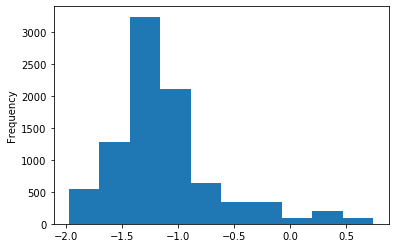

In [30]:
np.log10(df.FN).plot.hist()

## Statistical distribution of sfc.mix./FN

- histogram of individual FN observations

In [6]:
m = loadmat('../data/fn-compilation-database/randelhoff2016vertical/surface_FN/results_all.mat', squeeze_me=True)
m.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ntrz', 'NC', 'PC', 'time', 'lat', 'lon', 'NTR0', 'isice', 'Krho', 'eps', 'N2', 'FN', 'FN_gC', 'dsigth', 'dntr'])

In [7]:
df = pd.DataFrame({key: m[key] for key in ['FN', 'isice']})
df['logFN'] = np.log10(df.FN)

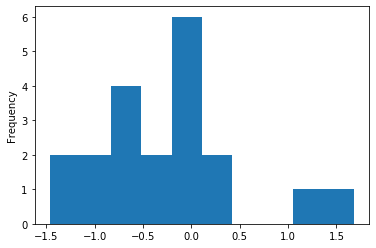

In [8]:
df.loc[df.isice==0, 'logFN'].plot.hist()

In [9]:
df.logFN.hvplot.kde()

:Distribution   [logFN]   (Density)

In [10]:
df.loc[df.FN<1,'FN'].hvplot.kde()

:Distribution   [FN]   (Density)